In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [73]:
titanic_data = pd.read_csv('train.csv')

In [74]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [75]:
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


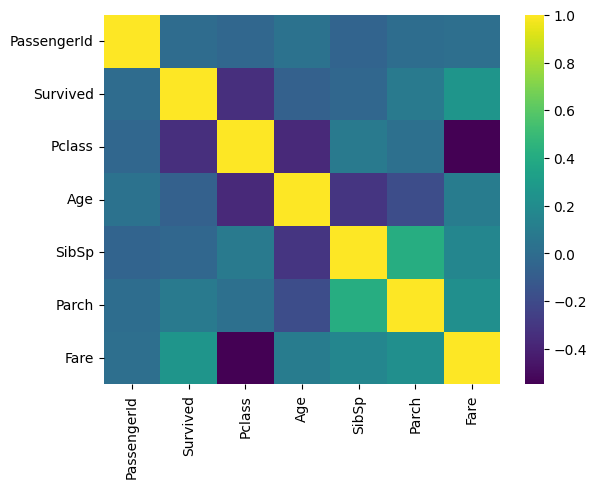

In [76]:
sns.heatmap(titanic_data.select_dtypes(include='number').corr(), cmap="viridis")
plt.show()

In [77]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass","Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

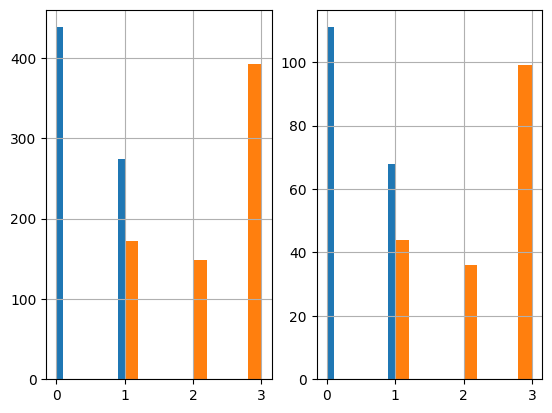

In [78]:
plt.subplot(121)
strat_train_set["Survived"].hist()
strat_train_set["Pclass"].hist()

plt.subplot(122)
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()

plt.show()

In [79]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 205 to 697
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        168 non-null    object 
 11  Embarked     711 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [80]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [81]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        
        column_names = ["C","S","Q","N"]    
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        matrix = encoder.fit_transform(X[['Sex']]).toarray()

        column_names = ["Female","Male"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X

In [82]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self,X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")

In [83]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("featureencoder", FeatureEncoder()),
                     ("featuredropper", FeatureDropper())])


In [84]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [85]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
205,206,0,3,2.000000,0,1,10.4625,0.0,0.0,1.0,1.0,0.0
166,167,1,1,29.426136,0,1,55.0000,0.0,0.0,1.0,1.0,0.0
29,30,0,3,29.426136,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
576,577,1,2,34.000000,0,0,13.0000,0.0,0.0,1.0,1.0,0.0
634,635,0,3,9.000000,3,2,27.9000,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
644,645,1,3,0.750000,2,1,19.2583,1.0,0.0,0.0,1.0,0.0
795,796,0,2,39.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
821,822,1,3,27.000000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
87,88,0,3,29.426136,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [86]:
strat_test_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,179.000000,179.000000,179.000000,142.000000,179.000000,179.000000,179.000000
mean,468.351955,0.379888,2.307263,30.798732,0.474860,0.307263,30.130774
std,257.186537,0.486720,0.841683,14.369216,1.066963,0.653859,44.413525
min,3.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,269.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,471.000000,0.000000,3.000000,30.000000,0.000000,0.000000,13.000000
75%,691.500000,1.000000,3.000000,40.000000,1.000000,0.000000,30.847900
max,885.000000,1.000000,3.000000,74.000000,8.000000,4.000000,263.000000


In [87]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']
scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 50, 100], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]
     }
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

,estimator,RandomForestClassifier()
,param_grid,"[{'max_depth': [None, 5, ...], 'min_samples_split': [2, 3, ...], 'n_estimators': [10, 50, ...]}]"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,50


In [89]:
final_clf = grid_search.best_estimator_

In [90]:
final_clf

,n_estimators,50
,criterion,'gini'
,max_depth,10
,min_samples_split,4
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [91]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [92]:
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived'] 
scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [93]:
final_clf.score(X_data_test, y_data_test)


0.8156424581005587

In [94]:
final_data = pipeline.fit_transform(titanic_data)

In [95]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [106]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']
scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [107]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 50, 100], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]
     }
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

,estimator,RandomForestClassifier()
,param_grid,"[{'max_depth': [None, 5, ...], 'min_samples_split': [2, 3, ...], 'n_estimators': [10, 50, ...]}]"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,50


In [108]:
prod_final_clf = grid_search.best_estimator_

In [109]:
titanic_test_data = pd.read_csv("test.csv")

In [110]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [113]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")
X_data_final_test = scaler.fit_transform(X_final_test)

C:\Users\JAY\AppData\Local\Temp\ipykernel_17108\377760205.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [114]:
predictions = prod_final_clf.predict(X_data_final_test)

In [118]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("predictions.csv", index=False)